Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.4, task size 31000, result size 15500, upload rate 200, download rate 400, T_b 200
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.08, and discount factor 0.4, task size 31000, result size 15500, upload rate 200, download rate 400, T_b 200
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.9, task size 31000, result size 15500, upload rate 200, download rate 400, T_b 200
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.08, and discount factor 0.9, task size 31000, result size 15500, upload rate 200, download rate 400, T_b 200
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.01, and discount factor 0.4, task size 31000, result size 15500, upload rate 200, download rate 400, T_b 200
Starting experiment with 10 vehicles, learning ra

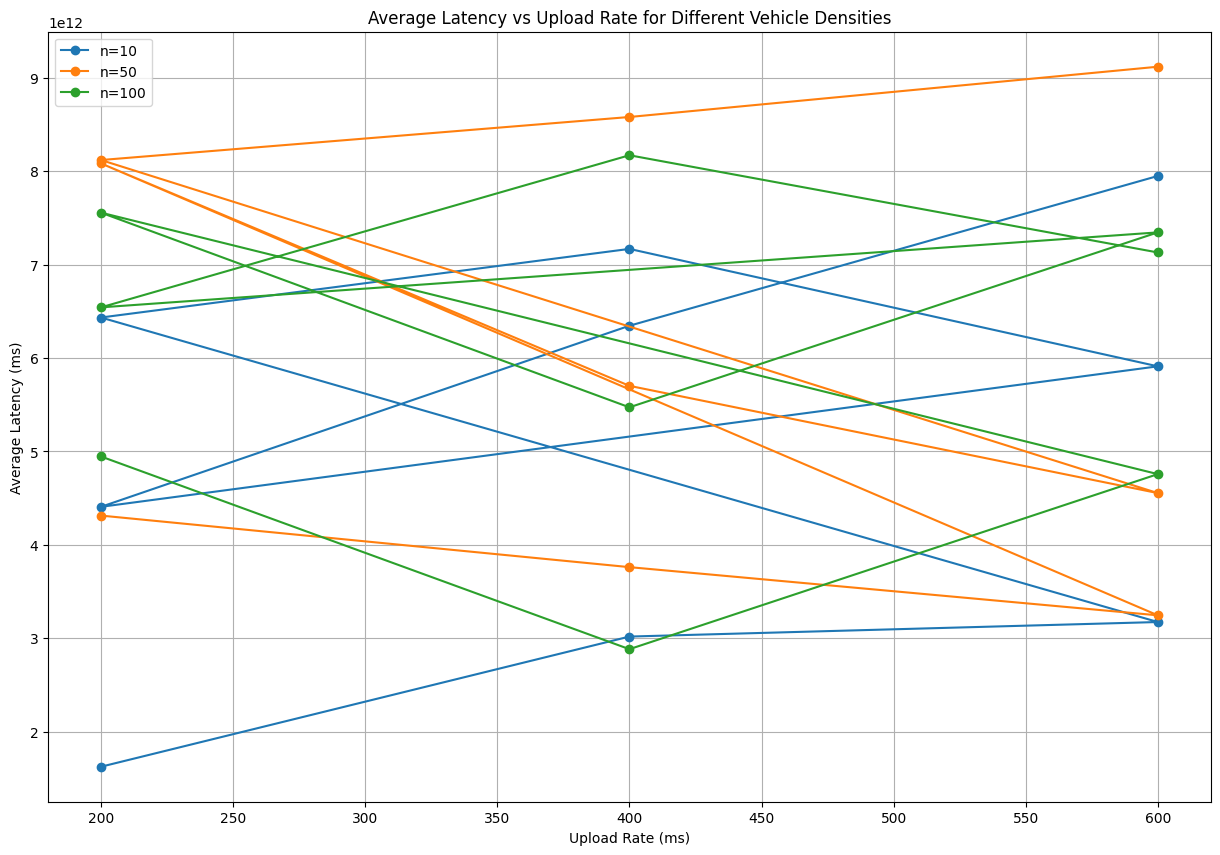

In [2]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

class TaskOffloadingEnv(gym.Env):
    def __init__(self, n_vehicles, d_V_values, bar_d_V_values, T_upload_RSU_values, T_download_RSU_values, T_b_values, F_RSU=10e9, max_steps=100):
        super(TaskOffloadingEnv, self).__init__()
        self.n = n_vehicles
        self.d_V_values = d_V_values
        self.bar_d_V_values = bar_d_V_values
        self.T_upload_RSU_values = T_upload_RSU_values
        self.T_download_RSU_values = T_download_RSU_values
        self.T_b_values = T_b_values
        self.F_RSU = F_RSU
        self.max_steps = max_steps
        self.current_step = 0

        self.action_space = spaces.Tuple((
            spaces.MultiBinary(self.n),
            spaces.Box(low=1e9, high=2e9, shape=(self.n,), dtype=np.float32)
        ))

        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(10 * self.n,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.d_V = np.random.choice(self.d_V_values, self.n) * 8
        self.c_V = np.random.randint(5, 6, self.n) * 1e3 / 8
        self.tau_V = np.random.randint(5, 6, self.n)
        self.bar_d_V = np.random.choice(self.bar_d_V_values, self.n) * 8
        self.f_V = np.random.randint(1, 2, self.n) * 1e9
        self.T_upload_RSU = np.random.choice(self.T_upload_RSU_values, self.n) * 1e6
        self.T_download_RSU = np.random.choice(self.T_download_RSU_values, self.n) * 1e6
        self.T_b = np.random.choice(self.T_b_values, self.n) * 1e6
        self.v_V = np.random.randint(20, 21, self.n)
        self.R = np.random.randint(1000, 1001, self.n)

        return np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_RSU, self.T_download_RSU, self.T_b, self.v_V, self.R])

    def step(self, action):
        self.current_step += 1

        x_V, F_RSU_V = action
        x_V = x_V.reshape(-1)
        F_RSU_V = F_RSU_V.flatten()

        T_total = 0
        tau_total = 0
        for i in range(self.n):
            tau_total += self.tau_V[i]
            T_V_j = (self.d_V[i] / self.T_upload_RSU[i]) + ((self.d_V[i] * self.c_V[i]) / (F_RSU_V[i])) + (self.bar_d_V[i] / self.T_download_RSU[i]) + 2*0.003*1e-3
            if x_V[i] == 0:
                T_V_i = (self.d_V[i] * self.c_V[i]) / self.f_V[i]
            else:
                if (self.v_V[i] * T_V_j) <= self.R[i]:
                    T_V_i = T_V_j
                else:
                    T_V_i = (self.d_V[i] / self.T_upload_RSU[i]) + \
                            ((self.d_V[i] * self.c_V[i]) / (F_RSU_V[i])) + \
                            (self.bar_d_V[i] / self.T_download_RSU[i]) + \
                            (self.v_V[i] * self.tau_V[i] * self.bar_d_V[i] / (self.R[i] * self.T_b[i])) + 2*0.003*1e-3

            T_total += T_V_i

        x_V = torch.as_tensor(x_V, dtype=torch.float32)
        F_RSU_V = torch.as_tensor(F_RSU_V, dtype=torch.float32)

        if (torch.sum(x_V * F_RSU_V) > self.F_RSU) or (T_total > tau_total):
            reward = -1e11
        else:
            reward = -T_total

        next_state = np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_RSU, self.T_download_RSU, self.T_b, self.v_V, self.R])

        done = self.current_step >= self.max_steps

        return next_state, reward, done, {}

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, std=0.2):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.actor_fc = nn.Linear(hidden_size, num_actions)
        self.actor_fc2 = nn.Linear(hidden_size, num_actions)
        self.critic = nn.Linear(hidden_size, 1)
        self.log_std = nn.Parameter(torch.ones(1, num_actions) * std)

    def forward(self, x):
        x = self.common(x)

        probs = torch.sigmoid(self.actor_fc(x))
        means = self.actor_fc2(x)
        stds = self.log_std.expand_as(means)

        value = self.critic(x)

        return probs, means, stds, value

def compute_returns(next_value, rewards, masks, gamma):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

def ppo_update(model, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, entropy_coefficient, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist_probs, means, stds, value = model(state)
            action_continuous = action[:, n_vehicles:]

            dist_normal = Normal(means, stds)
            new_log_prob_continuous = dist_normal.log_prob(action_continuous).sum(1, keepdim=True)

            action_discrete = action[:, :n_vehicles]
            dist_categorical = Categorical(logits=dist_probs)

            action_discrete_i_list = []
            new_log_prob_discrete_list = []
            for i in range(n_vehicles):
                action_discrete_i = action_discrete[:, i]
                action_discrete_i_list.append(action_discrete_i.unsqueeze(-1))
                new_log_prob_discrete_i = dist_categorical.log_prob(action_discrete_i)
                new_log_prob_discrete_list.append(new_log_prob_discrete_i.unsqueeze(-1))

            new_action_discrete_i = torch.cat(action_discrete_i_list, dim=-1)
            new_log_prob_discrete_i = torch.cat(new_log_prob_discrete_list, dim=-1)

            new_log_probs = new_log_prob_discrete_i + new_log_prob_continuous

            ratio = (new_log_probs / (old_log_probs))
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            optimizer.zero_grad()
            entropy = dist_categorical.entropy().mean() + dist_normal.entropy().mean()
            total_loss = actor_loss + 0.5 * critic_loss - entropy_coefficient * entropy
            total_loss.backward()

            max_norm = 0.5
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

def evaluate_policy(env, model, n_vehicles, episodes=2):
    total_latency = 0.0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                dist_probs, means, stds, _ = model(state)
                action_cat = Categorical(dist_probs)
                action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
                action_discrete = action_discrete.reshape(1, n_vehicles)
                action_continuous = Normal(means, stds).sample()
                action = (action_discrete, action_continuous.numpy())
            next_state, reward, done, _ = env.step(action)
            total_latency += -reward
            state = next_state

    average_latency = total_latency / episodes
    return average_latency

def run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma, d_V_values, bar_d_V_values, T_upload_RSU_values, T_download_RSU_values, T_b_values):
    env = TaskOffloadingEnv(n_vehicles=n_vehicles, d_V_values=d_V_values, bar_d_V_values=bar_d_V_values, T_upload_RSU_values=T_upload_RSU_values, T_download_RSU_values=T_download_RSU_values, T_b_values=T_b_values)
    num_inputs = env.observation_space.shape[0]
    num_actions = n_vehicles
    minimum_batch_size = 64
    model = ActorCritic(num_inputs, num_actions, hidden_size=512)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    max_frames = 1000
    frame_idx = 0
    latencies = []
    epochs_recorded = []

    state = env.reset()
    best_latency = float('inf')

    while frame_idx < max_frames:
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []

        for _ in range(100):
            state = torch.FloatTensor(state).unsqueeze(0)
            dist_probs, means, stds, value = model(state)
            dist_probs = dist_probs.squeeze(0)
            action_cat = Categorical(logits=dist_probs)
            action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
            action_discrete = action_discrete.reshape(1, n_vehicles)
            action_continuous = Normal(means, stds).sample()
            action_continuous_np = action_continuous.numpy()
            action = (action_discrete, action_continuous_np)
            next_state, reward, done, _ = env.step(action)
            log_prob = action_cat.log_prob(action_discrete) + Normal(means, stds).log_prob(action_continuous).sum(1, keepdim=True)

            states.append(state)
            actions.append(torch.cat([action_discrete, action_continuous], 1))
            rewards.append(reward)
            masks.append(1 - done)
            values.append(value)
            log_probs.append(log_prob)

            state = next_state
            frame_idx += 1

            if done:
                state = env.reset()

        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            _, _, _, next_value = model(next_state)

        returns = compute_returns(next_value, rewards, masks, gamma)
        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values
        ppo_epoch = 4
        ppo_update(model, optimizer, ppo_epoch, minimum_batch_size, states, actions, log_probs, returns, advantage, entropy_coefficient)

        if frame_idx % 100 == 0:
            latency = evaluate_policy(env, model, n_vehicles)
            latencies.append(latency)
            epochs_recorded.append(frame_idx)
            avg_latency = np.mean(latencies[-100:])
            if avg_latency <= best_latency:
                best_latency = avg_latency

    config_label = f'n={n_vehicles}, lr={learning_rate}, hcoeff={entropy_coefficient}, gamma={gamma}, d_V={d_V_values}, bar_d_V={bar_d_V_values}, upload={T_upload_RSU_values}, download={T_download_RSU_values}, T_b={T_b_values}'
    data = pd.DataFrame({
        'Iteration': epochs_recorded,
        'Latency at ' + config_label: latencies
    })
    all_results.append(data)

all_results = []
n_vehicles_options = [10, 50, 100]
d_V_options = [31000,310000,3100000] #31kbyte, 310kbyte, and 3.1Mbyte
bar_d_V_options = [15500,155000,1550000] #15.5kbyte, 155 kbyte, 1.55Mbyte
T_upload_RSU_options = [200, 400, 600] # 20ms, 40ms, 60ms
T_download_RSU_options = [400, 800, 1200] # 40ms, 60ms, 80ms
T_b_options = [200, 400, 600] # 100ms, 200ms, 300ms
best_configs = {
    10: [(0.003, 0.01, 0.4), (0.003, 0.08, 0.4), (0.003, 0.01, 0.9), (0.003, 0.08, 0.9), (0.0003, 0.01, 0.4), (0.0003, 0.08, 0.4), (0.0003, 0.01, 0.9), (0.0003, 0.08, 0.9)],
    50: [(0.003, 0.01, 0.4), (0.003, 0.08, 0.4), (0.003, 0.01, 0.9), (0.003, 0.08, 0.9), (0.0003, 0.01, 0.4), (0.0003, 0.08, 0.4), (0.0003, 0.01, 0.9), (0.0003, 0.08, 0.9)],
    100: [(0.003, 0.01, 0.4), (0.003, 0.08, 0.4), (0.003, 0.01, 0.9), (0.003, 0.08, 0.9), (0.0003, 0.01, 0.4), (0.0003, 0.08, 0.4), (0.0003, 0.01, 0.9), (0.0003, 0.08, 0.9)]
}

for n_vehicles in n_vehicles_options:
    for (d_V, bar_d_V) in zip(d_V_options, bar_d_V_options):
        for (T_upload_RSU, T_download_RSU, T_b) in zip(T_upload_RSU_options, T_download_RSU_options, T_b_options):
            #for T_b in T_b_options:
                for config in best_configs[n_vehicles]:
                    learning_rate, entropy_coefficient, gamma = config
                    print(f'Starting experiment with {n_vehicles} vehicles, learning rate {learning_rate}, '
                          f'entropy coefficient {entropy_coefficient}, and discount factor {gamma}, '
                          f'task size {d_V}, result size {bar_d_V}, upload rate {T_upload_RSU}, download rate {T_download_RSU}, T_b {T_b}')
                    run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma, [d_V], [bar_d_V], [T_upload_RSU], [T_download_RSU], [T_b])

combined_results = pd.concat(all_results)
file_path = 'latency_vs_vehicles_edge_task_result_rates_high_fixed.csv'
combined_results.to_csv(file_path, index=False)
# Extract the task size and result size from the column names
combined_results_melted = combined_results.melt(id_vars=['Iteration'], var_name='Configuration', value_name='Latency (ms)')
combined_results_melted['Vehicles'] = combined_results_melted['Configuration'].str.extract(r'n=(\d+)').astype(int)
combined_results_melted['Task Size'] = combined_results_melted['Configuration'].str.extract(r'd_V=\[(\d+)\]').astype(int)
combined_results_melted['Result Size'] = combined_results_melted['Configuration'].str.extract(r'bar_d_V=\[(\d+)\]').astype(int)
combined_results_melted['Upload Rate'] = combined_results_melted['Configuration'].str.extract(r'upload=\[(\d+)\]').astype(int)
combined_results_melted['Download Rate'] = combined_results_melted['Configuration'].str.extract(r'download=\[(\d+)\]').astype(int)
combined_results_melted['T_b'] = combined_results_melted['Configuration'].str.extract(r'T_b=\[(\d+)\]').astype(int)

# Group by the number of vehicles, task size, result size, upload rate, download rate, and T_b, and calculate the average latency
average_latencies = combined_results_melted.groupby(['Vehicles', 'Task Size', 'Result Size', 'Upload Rate', 'Download Rate', 'T_b'])['Latency (ms)'].mean().reset_index()

print(average_latencies)
plt.figure(figsize=(15, 10))
for n_vehicles in n_vehicles_options:
    subset = average_latencies[average_latencies['Vehicles'] == n_vehicles]
    plt.plot(subset['Upload Rate'], subset['Latency (ms)'], marker='o', label=f'n={n_vehicles}')

plt.title("Average Latency vs Upload Rate for Different Vehicle Densities")
plt.xlabel("Upload Rate (ms)")
plt.ylabel("Average Latency (ms)")
plt.grid(True)
plt.legend()
plt.show()
